# Hierarchical Graph Representation Learning with Differentiable PoolingLinks to the original paper:



Links to the original paper:
* ArXiv: <https://arxiv.org/abs/1806.08804>
* Code Repository: <https://github.com/RexYing/diffpool>

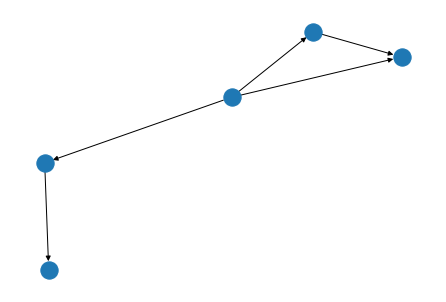

In [32]:
import torch as th
import matplotlib.pyplot as plt
import networkx as nx
import dgl

g = dgl.graph(([0, 0, 0, 1, 2], [1, 2, 4, 3, 4]))

X = th.rand(5, 2)

g.ndata['h'] = X

nx.draw(dgl.to_networkx(g))
plt.show()

In [33]:
g.ndata

{'h': tensor([[0.3621, 0.9701],
        [0.0459, 0.7961],
        [0.9720, 0.5743],
        [0.5102, 0.2210],
        [0.0549, 0.6686]])}

In [35]:
from dgl.nn.pytorch.conv.sageconv import SAGEConv
from torch.nn.functional import softmax

embed = SAGEConv(2, 2, 'mean')
pool = SAGEConv(2, 2, 'mean')

Z = embed(g, g.ndata['h'])
S = softmax(pool(g, g.ndata['h']))

Z, S

/tmp/ipykernel_72096/2924947254.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  S = softmax(pool(g, g.ndata['h']))


(tensor([[ 0.7517, -0.4331],
         [ 1.1428, -0.9247],
         [ 2.4888, -1.1730],
         [ 1.2903, -1.2077],
         [ 1.3463, -0.1149]], grad_fn=<AddBackward0>),
 tensor([[0.4319, 0.5681],
         [0.0751, 0.9249],
         [0.1332, 0.8668],
         [0.2168, 0.7832],
         [0.0797, 0.9203]], grad_fn=<SoftmaxBackward0>))

In [36]:
import numpy as np

Z = Z.detach().numpy()
S = S.detach().numpy()
A = g.adj().to_dense().numpy()

X_new = np.transpose(S) @ Z
A_new = np.transpose(S) @ A @ S

X_new, A_new

(array([[ 1.1289738, -0.6837117],
        [ 5.8909616, -3.169727 ]], dtype=float32),
 array([[0.15124375, 1.3527174 ],
        [0.43314913, 3.0628896 ]], dtype=float32))

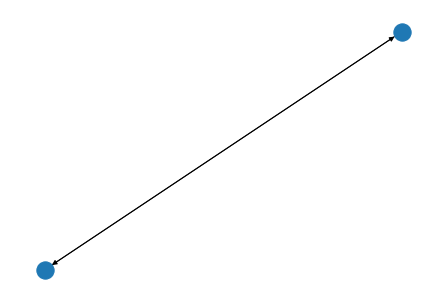

In [39]:
g_new = nx.from_numpy_matrix(A_new, create_using=nx.DiGraph)
g_new.remove_edges_from(nx.selfloop_edges(g_new))
nx.draw(g_new)
plt.show()

In [10]:
from dgl.data import tu

dataset = tu.LegacyTUDataset(name="ENZYMES")
train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(len(dataset) - train_size - test_size)

batch_size = 20

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(
    dataset, (train_size, val_size, test_size))
train_dataloader = dgl.dataloading.GraphDataLoader(dataset_train, batch_size=batch_size)
val_dataloader = dgl.dataloading.GraphDataLoader(dataset_val, batch_size=batch_size)
test_dataloader = dgl.dataloading.GraphDataLoader(dataset_test, batch_size=batch_size)

input_dim, label_dim, max_num_node = dataset.statistics()
print("++++++++++STATISTICS ABOUT THE DATASET")
print("dataset feature dimension is", input_dim)
print("dataset label dimension is", label_dim)
print("the max num node is", max_num_node)
print("number of graphs is", len(dataset))

Extracting file to /home/dstoll/.dgl/ENZYMES
++++++++++STATISTICS ABOUT THE DATASET
dataset feature dimension is 18
dataset label dimension is 6
the max num node is 126
number of graphs is 600


In [12]:
hidden_dim = 64
embedding_dim = 64
pool_ratio = 0.15

assign_dim = int(max_num_node * pool_ratio)
print("++++++++++MODEL STATISTICS++++++++")
print("model hidden dim is", hidden_dim)
print("model embedding dim for graph instance embedding", embedding_dim)
print("initial batched pool graph dim is", assign_dim)
activation = F.relu

++++++++++MODEL STATISTICS++++++++
model hidden dim is 64
model embedding dim for graph instance embedding 64
initial batched pool graph dim is 18


Number of nodes for each graph element in the batch: tensor([73, 27, 30, 20, 11])
Number of edges for each graph element in the batch: tensor([313, 141, 148,  96,  51])
The original graphs in the minibatch:
[Graph(num_nodes=73, num_edges=313,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=27, num_edges=141,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=30, num_edges=148,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=96,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=11, num_edges=51,
      ndata_schemes={'label': Scheme(shape=(), dtype=to

In [7]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [9]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.09417040358744394
